# Huggett Model

Contents:

- [Huggett Model](#Huggett-Model)  
  - [Model Overview](#Model-Overview) 
  - [Solving for a Stationary Equilibrium](#Solving-for-a-Stationary-Equilibrium) 
  - [Analysis](#Analysis)   

This lab includes:

(1) A brief overview of the Huggett's incomplete markets model;

(2) A computational approach to solving for stationary equilibria for Huggett's model;

(3) Analyses of changes in the stationary equilibrium by varying the model parameters.

---

## Model Overview

### Intuitive Description

Huggett (1993) sets up and analyzes a pure consumption-loans economy. 

The economy is populated by a unit mass of households.

Each household lives to maximize their lifetime utility, which is a function of its consumption path.

In each period, each household is endowed stochastically and idiosyncratically with some income.

More specifically, the household's endowment follows a Markov chain $(\mathcal{P},\overline{s})$.

The stochastic and idiosyncratic nature of the endowment process in the economy creates risk for each household.

The existence of risk creates the need for risk management / insurance against the risk.

The vehicle for such insurance is the centralized loan market, where households can borrow and lend at some constant risk-free interest rate $r$.

Total borrowing is bounded by some $\phi > 0$ (otherwise debt levels could blow up).

$\ast$ The level of assets is restricted to the *discrete* set $\mathcal{A} = [\overline{a}_1, \ldots, \overline{a}_m]$, where the lower bound on assets is $\overline{a}_1 = - \phi$.

(Why does $\overline{a}_1 = - \phi$ make sense? Think abut the intuitive relationship between assets and debt.)

### Stationary Equilibrium Definition

Given a borrowing limit $\phi$ a **stationary equilibrium** is an interest rate $r$, a policy function $g(a,s)$, and a stationary distribution $\lambda(a,s)$ for which 

#### (a) 

Given $r$, the policy function $g(a,s)$ solves the household's optimum problem

\begin{align*}
\max_{ \{c_t,a_{t+1}\} } E_0 \sum_{t=0}^\infty \beta^t u(c_t) \, ,
\end{align*}

subject to 

\begin{align*}
c_t + a_{t+1} &= (1+r) a_t + w s_t \, , \\
a_{t+1} &\in \mathcal{A} \, ,
\end{align*}

where $\beta \in (0,1)$, $u(c)$ has the usual properties, and $\beta (1+r) < 1$.

#### (b)

The probability distribution $\lambda(a,s)$ is the invariant distribution of the Markov chain on $(a,s)$ induced by the Markov chain $(\mathcal{P},\overline{s})$ and the optimal policy $g(a,s)$.

Let's think a bit about this Markov chain. 

Define $x = (a,s)$ as a single state variable. 

More specifically, if $i = 1,\ldots,n$ indexes the asset level grid $\mathcal{A}$, and $h = 1,\ldots,m$ indexes the possible income states $\{ws_1,\ldots,ws_m\}$, then the $j$-th element of $x$ is is $x_j = (a_i, s_i)$, where $j= (i-1)m + h$:

\begin{align*}
x' = [(\overline{a}_1,\overline{s}_1),\ldots,(\overline{a}_1,\overline{s}_m),
(\overline{a}_2,\overline{s}_1),\ldots,(\overline{a}_2,\overline{s}_m),
\ldots, (\overline{a}_n,\overline{s}_1),\ldots,(\overline{a}_n,\overline{s}_m)] \, .
\end{align*}

The Markov chain for $x$ is determined by the following equation:

\begin{align*}
P[(a_{t+1} = a', s_{t+1} =s') \,|\, (a_t = a, s_t = s) ] 
&= 
P(a_{t+1} = a\prime \,|\, a_t =a, s_t = s) \cdot P(s_{t+1} = s' \,|\, s_t = s)
\\
&=
    \mathcal{I}(a\prime, a,s) \mathcal{P}(s,s') \, ,
\end{align*}
where $ \mathcal{I}(a\prime, a,s) = 1$ if $a' = g(a,s)$ and zero otherwise, and $\mathcal{P}$ is the given Markov chain on $s$.

The Markov process defined by the above equation corresponds to a $(n \cdot m) \times (n \cdot m)$ transition matrix $P$.

The stationary distribution corresponding to the transition matrix $P$ is a vector $\pi_\infty$ with $n \cdot m$ entries.

#### (c)

When $\lambda(a,s)$ describes the cross-section of households at each date, the loan market clears:

\begin{align*}
\sum_{a,s} \lambda(a,s) g(a,s) = 0 \, .
\end{align*}

---

## Solving for a Stationary Equilibrium

First we load all necessary packages.

In [37]:
using Parameters
using QuantEcon
using LinearAlgebra
using SparseArrays
using Plots
using LaTeXStrings

We then define a structure called `Agent` that will contain all agent-specific model parameters.

In [3]:
mutable struct Agent
  σ::Float64 # risk aversion parameter
  β::Float64 # discount factor
  r::Float64 # interest rate 
  w::Float64 # endowment
  e::Vector{Float64} # vector of productivities
  π::Vector{Float64} # probability weights on productivities
  agrid::Vector{Float64} # grid for asset holdings 
end;

Then we construct a function `utility` that will take agent parameters and the level of consumption as inputs, and return the utility level.

In [4]:
"""
Utility function for agent when consumption is a real number
"""
function utility(agent::Agent,c::Real)
    
    σ = agent.σ # Store risk-aversion parameter
    
    # Define the utility mapping 
    # condition on the input `c`
    if c > 0
        if σ == 1
          return log(c) # if σ = 1, CRRA utility is log
        else
          return c^(1-σ)/(1-σ) # if σ != 1, regular specification
        end
    else
        return -Inf # infinite disutility if c∈(-∞,0]
    end
end;

Allow for `utility` to be applied to a vector of different consumption levels as well.

In [5]:
"""
Utility function when consumption is a vector
"""
function utility(agent::Agent,cvec)
  u(c) = utility(agent,c)
  return u.(cvec)
end;

Create a function `iterateBellman` that applies a single Bellman mapping to an initial value function guess.
As always, the model parameters must also be inputted.

In [6]:
"""
  iterateBellman(agent::Agent,Vcont)

Iterates on the bellman equation using continuation value function Vcont
"""
function iterateBellman(agent::Agent,Vcont)
  @unpack σ,agrid,π,w,e,r,β = agent #unpack parameters of agent
  u(c) = utility(agent,c)#shorthand for utility
  Na = length(agrid)
  S = length(e)

  EVcont = Vcont*π #precompute expected value

  #solve for each state
  #preallocate space for V and a_policy
  V = similar(Vcont)
  a_policy = similar(Vcont,Int)
  for s  in 1:S
    for ia_ in 1:Na
      cvec = e[s]*w + (1+r)*agrid[ia_] - agrid #possible consumption values for each asset position
      obj = u(cvec) + β * EVcont #objective for each asset position

      V[ia_,s],a_policy[ia_,s] = findmax(obj) #choose maximum asset position
    end
  end
  return V,a_policy
end;

In [7]:
"""
  iterateBellman_alt(agent::Agent,Vcont)

Iterates on the bellman equation using continuation value function Vcont.  Exploits
that a_policy in increasing in a and that the value function is concave.
"""
function iterateBellman_alt(agent::Agent,Vcont)
  @unpack σ,agrid,π,w,e,r,β = agent
  u(c) = utility(agent,c)
  Na = length(agrid)
  S = length(e)
  EVcont = Vcont*π #precompute expected value

  EVcont = Vcont*π #precompute expected value

  #solve for each state
  #preallocate space for V and a_policy
  V = similar(Vcont) #creates V the same size as Vcont
  a_policy = similar(Vcont,Int) #note a_policy needs to be integers
  for s  in 1:S
    aprev = 1 #stores for the last ia_ the optimal policy
    for ia_ in 1:Na
      maxobj = -Inf #stores the maxobj up to this point
      for ia in aprev:Na #start iterating at a_policy[ia_-1,s]
        c = w*e[s] + (1+r)*agrid[ia_] - agrid[ia] #get consumption for this ia
        obj = u(c) + β * EVcont[ia] #get objective
        if obj >= maxobj #check if increasing ia improves utility
          V[ia_,s],a_policy[ia_,s] = obj,ia #if so store values
          maxobj = obj#and update maxobj
        else
          break #if it decreases utility end for loop, we have found our max
        end
      end
      aprev = a_policy[ia_,s]#store the max in aprev for next ia_
    end
  end
  return V,a_policy
end;

Create function `solveBellman` that applies the Bellman mapping iteratively until convergence. 

In [8]:
"""
  solveBellman(agent::Agent,V0,ϵ=1e-6)

Solves the bellman equation for a given guess of V0 using iterateBellman
"""
function solveBellman(agent::Agent,V0,ϵ=1e-6)
  Vcont = V0
  a_policy = similar(V0,Int)
  diff = 1.

  while diff > ϵ
    V,a_policy = iterateBellman(agent,Vcont)
    diff = norm((V-Vcont)[:],Inf)
    Vcont = V
  end
  return Vcont,a_policy
end;

In [9]:
"""
  solveBellman_alt(agent::Agent,V0,ϵ=1e-6)

Solves the bellman equation for a given guess of V0 using iterateBellman_alt
"""
function solveBellman_alt(agent::Agent,V0,ϵ=1e-6)
  Vcont = V0
  a_policy = similar(V0,Int)
  diff = 1.

  while diff > ϵ
    V,a_policy = iterateBellman_alt(agent,Vcont)
    diff = norm((V-Vcont)[:],Inf)
    Vcont = V
  end
  return Vcont,a_policy
end;

Now let's create a function `constructTransitionMatrix` that... constructs the transition matrix.

In [10]:
function constructTransitionMatrix(agent::Agent,a_policy)
  @unpack π,agrid = agent

  N = length(agrid)
  S = length(π)

  H = spzeros(N*S,N*S) #sparse matrix to save on space
  for n_ in 1:N
    for s in 1:S
      i_ = n_+N*(s-1) # index for ia_,s
      n = a_policy[n_,s]
      for sprime in 1:S
        i = n+N*(sprime-1)
        #probability of transitioning from state ia_,s to ia,sprime
        H[i_,i] = π[sprime]
      end
    end
  end
  return H
end;

We then create a function `find_stationary_distribution` that updates the transition matrix given a uniform initial distribution until it converges to a stationary distribution (represented by a vector).

In [11]:
function find_stationary_distribution(agent::Agent,a_policy)
  H = constructTransitionMatrix(agent,a_policy)
  N = size(H)[1]
  π0 = ones(1,N)/N
  diff = 1.
  while diff > 1e-10
    π1 = π0*H
    diff = norm(π1-π0,Inf)
    π0 = π1
  end

  return π0
end;

Lastly, we create a function `computeassetdemand` that solves for the asset demand in the stationary equilibrium.

In [12]:
"""
  computeassetdemand(agent::Agent,r)

Computes asset demanded in steady state at interest rate r and
wage w
"""
function computeassetdemand(agent::Agent,r,w)
  agent.r = r
  agent.w = w

  N = length(agent.agrid)
  S = length(agent.e)
  V0 = zeros(N,S)

  V,a_policy = solveBellman_alt(agent,V0)
  λss = find_stationary_distribution(agent,a_policy)

  A = 0.
  for n in 1:N
    for s in 1:S
      i = n + (s-1)*N
      A  = A + λss[i] * agent.agrid[n]
    end
  end

  λss = reshape(λss,N,S) #λss[ia_,s] is the fraction of agents with assets agrid[ia]
  #and productivity e[s]

  return dot(agent.agrid,sum(λss,dims=2)) #agrid*πss gives average assets for each productivity
end;

---

## Analysis

Let's use our code to solve for the equilibrum asset demand.

In [13]:
agent = Agent(2.,0.96,.02,1.,[.8,1.,1.2],ones(3)/3,LinRange(-.5,25.,1000))
computeassetdemand(agent,.03435,1.)

0.00042094784010208216

In [44]:
N = 10
M = 3
Σ = LinRange(2.,50.,N)
Φ = LinRange(-1.0,-0.1,M)
A = zeros(N,M)

for i in 1:N
    for j in 1:M
        agent = Agent(Σ[i],0.96,0.02,1.,[.8,1.,1.2],ones(3)/3,LinRange(Φ[j],25.,1000))
        A[i,j] = computeassetdemand(agent,.03435,1.)
    end 
end

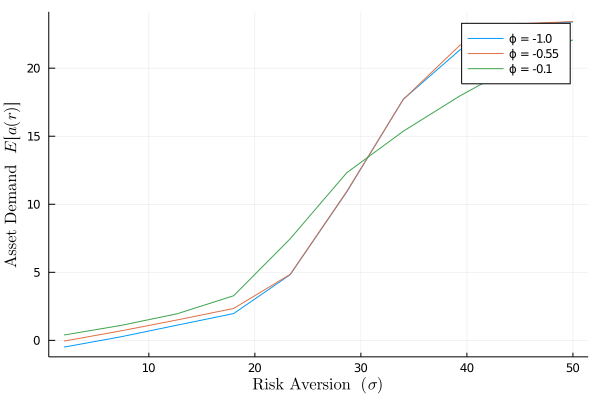

In [45]:
fig = plot();
for i in 1:M
    plot!(fig,Σ,A[:,i],label="ϕ = $(round(Φ[i],digits=2))")
end 
plot!(fig, xlabel=L"\textrm{Risk Aversion  } (\sigma)", ylabel=L"\textrm{Asset Demand  } E\,[a(r)]")
fig